In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image

%matplotlib inline

# Loading Data

In [2]:
data_svm_train = np.loadtxt('svm-train.txt')
data_svm_test = np.loadtxt('svm-test.txt')

In [3]:
x_svm_train, y_svm_train = data_svm_train[:, 0: 2], data_svm_train[:, 2].reshape(-1, 1)
x_svm_test, y_svm_test = data_svm_test[:, 0: 2], data_svm_test[:, 2].reshape(-1, 1)

# Visualize Data

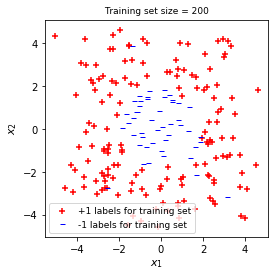

In [4]:
#Select positive target and negative target
positive_index = np.where(y_svm_train>0)[0]
x_positive = x_svm_train[positive_index]

negative_index = np.where(y_svm_train<=0)[0]
x_negative = x_svm_train[negative_index]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (x_positive[:,0], x_positive[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (x_negative[:,0], x_negative[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_svm_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [5]:
# Change target to 0-1 label
y_svm_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_svm_train))).reshape(-1, 1)

# Decision Tree Class

In [6]:
class DTree():
    '''
    Decision Tree class
    
    :attribute train: a numpy array of training data in this node
    :attribute value: value estimated by this node
    :attribute split_score_function: function used for compute splitting criterion
    :attribute leaf_value_estimator: function used for estimating leaf value
    :attribute is_leaf(boolen): indicator of leaf node
    :attribute depth: depth of this node
    :attribute min_sample: threshold of minimum sample for splitting
    :attribute max_depth: threshold of maximum depth of decision tree
    :attribute split_id: feature used for splitting this node
    :attribute split_value: value used for splitting this node
    :attribute left: DTree_classifier object
    :attribute right: DTree_classifier object
    
    :method split_node: splitting internal node
    :method split_tree: searching split_id and split_value based on split_score_function
    :method predict: predicting leaf value based on leaf_value_estimator
    '''
    def __init__(self, train_data, train_target, split_score_function, leaf_value_estimator,\
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier
        
        :param train_data: a numpy array of training data, shape = (n, m)
        :param train_target: a numpy array of labels, shape = (n, 1)
        :param split_score_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.train = train_data
        self.split_score_function = split_score_function
        self.leaf_value_estimator = leaf_value_estimator
        self.value = leaf_value_estimator(train_target)
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
    
    def split_node(self, train_data, train_target):
        '''
        Splitting the internal node of decision tree.
        
        :param train_data: a numpy array of training data, shape = (n, m)
        :param train_target: a numpy array of labels, shape = (n, 1)
        
        :return left_index: index of left tree
        :return right_index: index of right tree
        '''
        if len(train_data) <= self.min_sample or self.depth >= self.max_depth:
            self.is_leaf = True
            return None, None

        # split this node
        self.split_id, self.split_value = self.split_tree(train_data, train_target)

        if self.split_id == -1:
            self.is_leaf = True
            return None, None

        # create subtree on left and right
        self.is_leaf = False
        left_index = np.where(train_data[:, self.split_id] <= self.split_value)
        right_index = np.where(train_data[:, self.split_id] > self.split_value)
        return left_index, right_index

    def split_tree(self, train_data, train_target):
        '''
        Split the internal node of decision tree
        
        :param train_data: a numpy array of training data, shape = (n, m)
        :param train_label: a numpy array of labels, shape = (n, 1)
        
        :return split_id: feature used for splitting this node, -1 if splitting cannot decrease entropy
        :return split_value: value used for splitting this node, np.inf if splitting cannot decrease entropy
        '''
        split_id = -1
        split_value = np.inf
        min_score = self.split_score_function(train_target)
        
        for attr_id in range(train_data.shape[1]):
            attr_value = sorted(list(set(train_data[:, attr_id])))
            for i in range(len(attr_value) - 1):
                v = (attr_value[i] + attr_value[i + 1]) / 2.
                
                left_index_temp = np.where(train_data[:, attr_id] <= v)[0]
                right_index_temp = np.where(train_data[:, attr_id] > v)[0]
                
                left_score = self.split_score_function(train_target[left_index_temp])
                right_score = self.split_score_function(train_target[right_index_temp])
                
                score_mean = (len(left_index_temp) * left_score + len(right_index_temp) * right_score) / float(len(train_target))
                
                if score_mean < min_score: # if entropy decreases, update split_id and split_value 
                    split_id = attr_id
                    split_value = v
                    min_score = score_mean

        return split_id, split_value

    def predict(self, instance):
        '''
        Predict label by decision tree
        
        :param instance: a numpy array with new data, shape (1, m)
        
        :return self.label: predicted label
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict(instance)
        else:
            return self.right.predict(instance)

# Decision Tree Classifier

In [7]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    entropy = 0.
    for prob in prob_list:
        if prob == 0.:
            pass
        else:
            entropy += -1. * prob * np.log(prob)
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    gini = 0.
    for prob in prob_list:
        gini += prob * (1 - prob)
    return gini

In [8]:
def most_common_label(train_target):
    '''
    Find most common label
    '''
    label_cnt = Counter(train_target.reshape(len(train_target)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [9]:
class DTree_classifier(DTree):
    '''
    Decision Tree Classifier class, inherit from DTree class
    
    :attribute criterion_dict: dictionary containing the criterion function
    :attribute label_list: a list containing all possible labels
    :attribute label_probability: a list containing probability of each possible label
    
    :method predict_prob: predict label probability vector
    '''
    
    criterion_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }
    
    def __init__(self, train_data, train_target, criterion='entropy', depth=0, min_sample=5, max_depth=10, label_list=None):
        '''
        Initialize DTree_classifier object
        :param criterion(str): criterion of splitting internal node
        :param label_list: a list containing all possible labels
        '''
        
        DTree.__init__(self, train_data, train_target, self.criterion_dict[criterion], most_common_label,\
                      depth=depth, min_sample=min_sample, max_depth=max_depth) # Ininitialize a DTree object
        
        # collect possible label list
        if label_list is None:
            label_cnt = Counter(train_target.reshape(len(train_target)))
            self.label_list = sorted(label_cnt.keys())
        else:
            self.label_list = label_list
        
        # compute label probability vector
        self.label_probability = self.compute_probability(train_target) # compute label probability vector
            
        # split internal node
        left_index, right_index = self.split_node(train_data, train_target)

        # if the internal node can be splitted, define left and right subtree
        if (not (left_index is None)) and (not (right_index is None)):
            
            self.left = DTree_classifier(train_data[left_index], train_target[left_index], criterion=criterion,\
                                         depth=self.depth+1, max_depth=self.max_depth, label_list=self.label_list)
            
            self.right = DTree_classifier(train_data[right_index], train_target[right_index], criterion=criterion,\
                                          depth=self.depth+1, max_depth=self.max_depth, label_list=self.label_list)
    
    def compute_probability(self, train_target):
        '''
        Compute probability vector
        '''
        label_cnt = Counter(train_target.reshape(len(train_target)))
        prob_vector = np.zeros(len(self.label_list))
        for i in range(len(self.label_list)):
            label = self.label_list[i]
            label_freq = label_cnt[label]
            label_prob = label_freq / float(len(train_target))
            prob_vector[i] = label_prob
        return prob_vector
    
    def predict_prob(self, instance):
        '''
        Predict label by decision tree
        
        :param instance: a numpy array with new data, shape (1, m)
        
        :return self.label: predicted label
        '''
        if self.is_leaf:
            return self.label_probability
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_prob(instance)
        else:
            return self.right.predict_prob(instance)

# Decision Tree Boundary

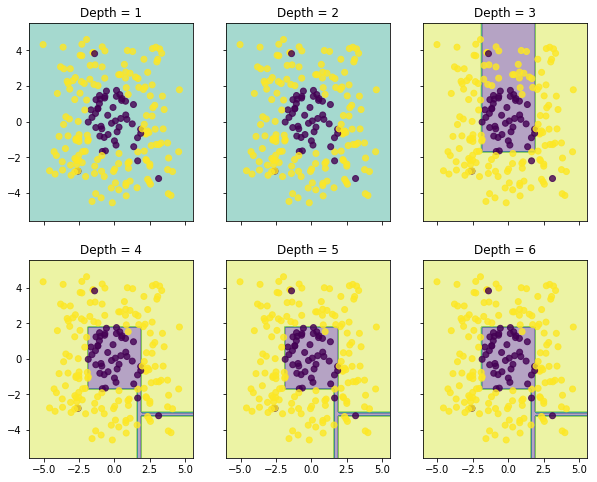

In [10]:
# Training classifiers with different depth
clf1 = DTree_classifier(x_svm_train, y_svm_train_label, criterion='entropy', max_depth=1)
clf2 = DTree_classifier(x_svm_train, y_svm_train_label, criterion='entropy', max_depth=2)
clf3 = DTree_classifier(x_svm_train, y_svm_train_label, criterion='entropy', max_depth=3)
clf4 = DTree_classifier(x_svm_train, y_svm_train_label, criterion='entropy', max_depth=4)
clf5 = DTree_classifier(x_svm_train, y_svm_train_label, criterion='entropy', max_depth=5)
clf6 = DTree_classifier(x_svm_train, y_svm_train_label, criterion='entropy', max_depth=6)

# Plotting decision regions
x_min, x_max = x_svm_train[:, 0].min() - 1, x_svm_train[:, 0].max() + 1
y_min, y_max = x_svm_train[:, 1].min() - 1, x_svm_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_svm_train[:, 0], x_svm_train[:, 1], c=y_svm_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [11]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)
clf.fit(x_svm_train, y_svm_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [12]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

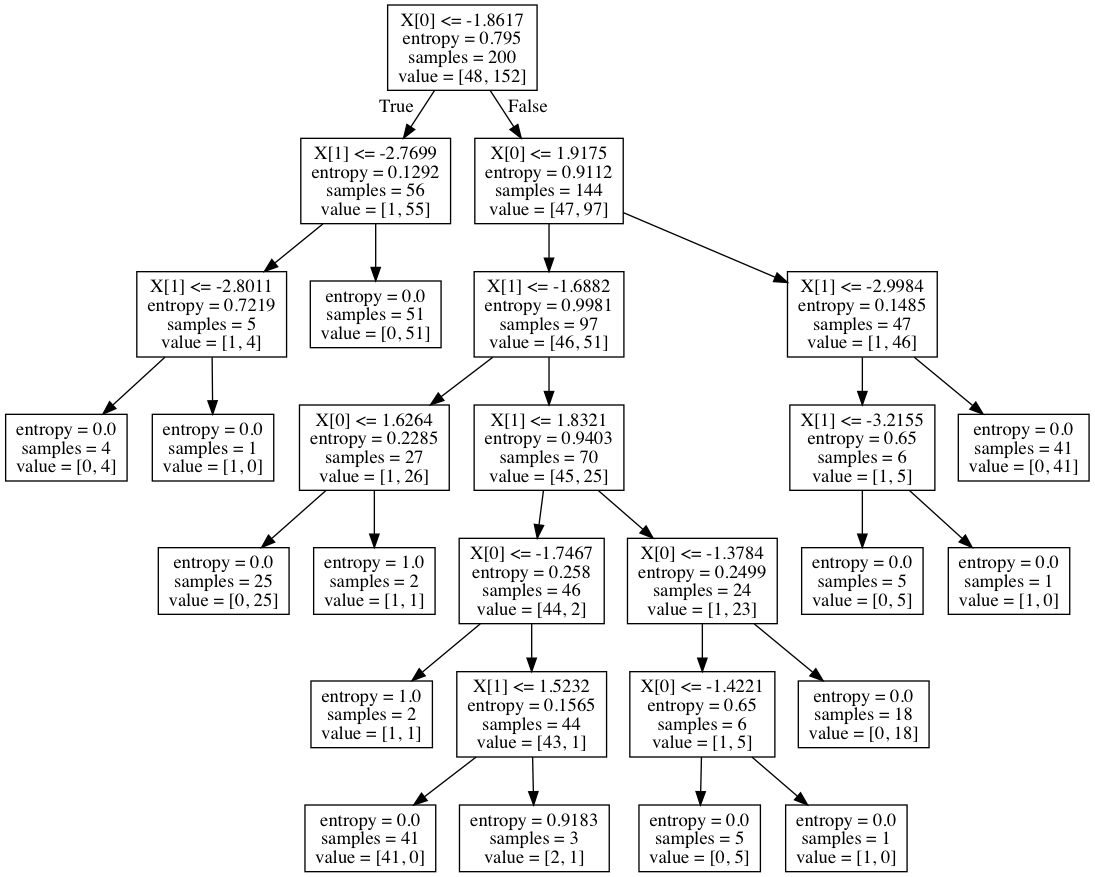

In [13]:
Image(filename='tree_classifier.png')

In [14]:
# compare first splitting point
print('Split_id of root node: {}'.format(clf2.split_id))
print('Split_value of root node: {}'.format(clf2.split_value))
print('left child size: {}'.format(clf2.left.train.shape[0]))
print('right child size: {}'.format(clf2.right.train.shape[0]))
print('right chile probability: {}'.format(clf2.right.label_probability))

Split_id of root node: 0
Split_value of root node: -1.8616606665
left child size: 56
right child size: 144
right chile probability: [ 0.32638889  0.67361111]


The above result shows that our model is consitent with decision tree model from sklearn.

# Decision Tree Regressor

In [15]:
def mean_square_error(train_target):
    '''
    Calulate the mean square error of given target list
    
    :param train_target: a numpy array of targets shape = (n, 1)
    :return mse
    '''
    mean_value = train_target.mean()
    mse = ((train_target - mean_value)**2).mean()
    return mse

def mean_absolute_error(train_target):
    '''
    Calulate the mean absolute error of given target list
    
    :param train_target: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    mean_value = train_target.mean()
    mae = (abs(train_target - mean_value)).mean()
    return mae

In [16]:
def mean_value(train_target):
    '''
    mean value estimator
    '''
    return train_target.mean()

def median_value(train_target):
    '''
    median value estimator
    '''
    return np.median(train_target)

In [17]:
class DTree_regressor(DTree):
    '''
    Decision Tree Regressor class, inherit from DTree class
    
    :attribute criterion_dict: dictionary containing the criterion function
    :attribute estimator_dict: dictionary containing the estimation function
    '''
    
    criterion_dict = {
        'mse': mean_square_error,
        'mae': mean_absolute_error
    }
    
    estimator_dict = {
        'mean': mean_value,
        'median': median_value
    }
    
    def __init__(self, train_data, train_target, criterion='mse', estimator='mean', depth=0, min_sample=5, max_depth=10):
        '''
        Initialize DTree_regressor object
        :param criterion(str): criterion of splitting internal node
        :param estimator(str): value estimator of internal node
        '''
        
        DTree.__init__(self, train_data, train_target, self.criterion_dict[criterion], self.estimator_dict[estimator],\
                      depth=depth, min_sample=min_sample, max_depth=max_depth) # Ininitialize a DTree object
            
        # split internal node
        left_index, right_index = self.split_node(train_data, train_target)

        # if the internal node can be splitted, define left and right subtree
        if (not (left_index is None)) and (not (right_index is None)):
            
            self.left = DTree_regressor(train_data[left_index], train_target[left_index], criterion=criterion, estimator=estimator,\
                                        depth=self.depth+1, max_depth=self.max_depth)
            
            self.right = DTree_regressor(train_data[right_index], train_target[right_index], criterion=criterion,estimator=estimator,\
                                         depth=self.depth+1, max_depth=self.max_depth)

In [18]:
tree_reg = DTree_regressor(x_svm_train, y_svm_train, criterion='mse', estimator='mean')

# Compare decision tree with tree model in sklearn

In [19]:
treg_sk = DecisionTreeRegressor(max_depth=3, min_samples_split=5, criterion='mse')
treg_sk.fit(x_svm_train, y_svm_train)
export_graphviz(treg_sk, out_file='tree_regressor.dot')

In [20]:
!dot -Tpng tree_regressor.dot -o tree_regressor.png

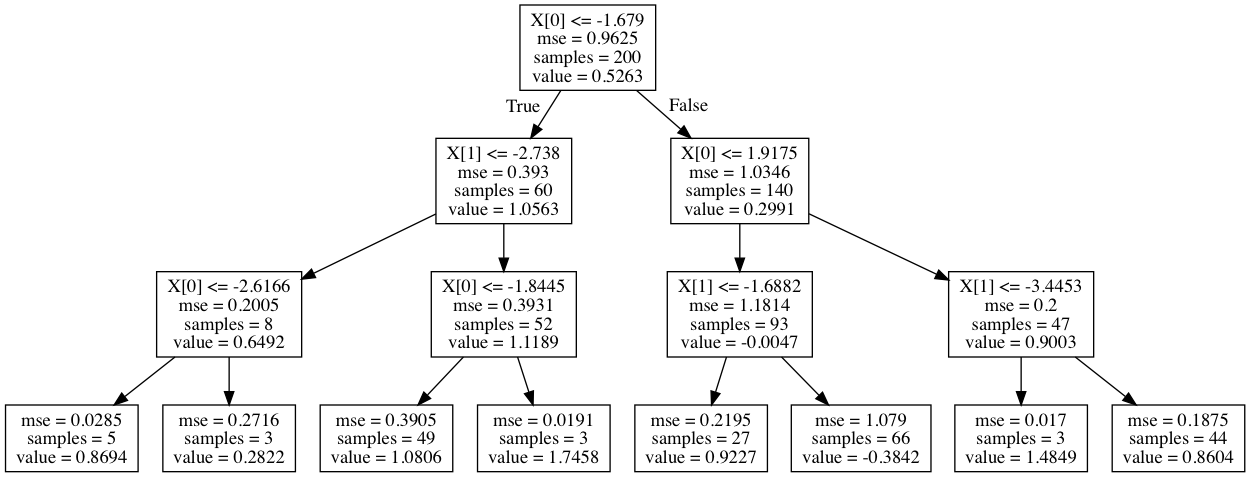

In [21]:
Image(filename='tree_regressor.png')

In [22]:
# compare first splitting point
print('Split_id of root node: {}'.format(tree_reg.split_id))
print('Split_value of root node: {}'.format(tree_reg.split_value))
print('root size: {}'.format(tree_reg.train.shape[0]))
print('roo5t value: {}'.format(tree_reg.value))

Split_id of root node: 0
Split_value of root node: -1.67902733099
root size: 200
roo5t value: 0.526258727876


The above result shows that our model is consitent with decision tree model from sklearn

# Gradient Boosting

In [23]:
#Pseudo-residual function.
#Here you can assume that we are using L2 loss

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [24]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        predict_value = np.zeros((len(train_target), 1))
        pseodo_residual = self.pseudo_residual_func(train_target, predict_value)
        model_dict = {}
        for i in range(self.n_estimator):
            decision_stump = DTree_regressor(train_data, pseodo_residual, min_sample=self.min_sample, max_depth=self.max_depth)
            model_dict[i] = decision_stump
            predict_value += self.learning_rate * np.array([decision_stump.predict(x) for x in train_data]).reshape(-1, 1)
            pseodo_residual = self.pseudo_residual_func(train_target, predict_value)
        self.model_dict = model_dict
    
    def predict(self, test_data):
        '''
        Predict value
        '''
        predict_vector = np.zeros((len(test_data), 1))
        for i in range(self.n_estimator):
            predict_temp = np.array([self.model_dict[i].predict(x) for x in test_data]).reshape(-1, 1)
            predict_vector += self.learning_rate * predict_temp
        return predict_vector

# Gradient Boosting Visualization

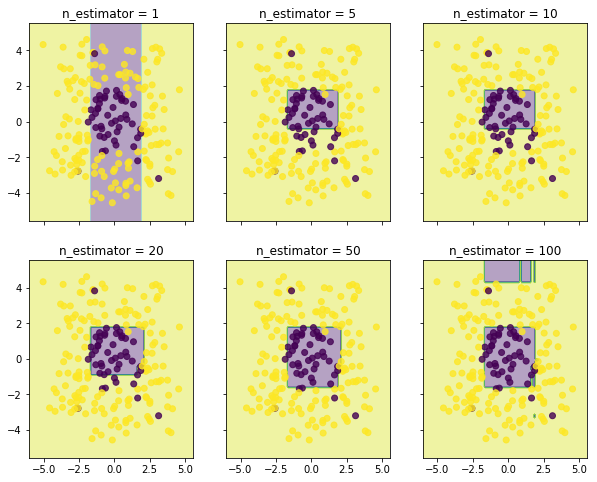

In [25]:
# Plotting decision regions
x_min, x_max = x_svm_train[:, 0].min() - 1, x_svm_train[:, 0].max() + 1
y_min, y_max = x_svm_train[:, 1].min() - 1, x_svm_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbt.fit(x_svm_train, y_svm_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_svm_train[:, 0], x_svm_train[:, 1], c=y_svm_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

# 1-D GBM visualization

In [26]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')

In [27]:
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

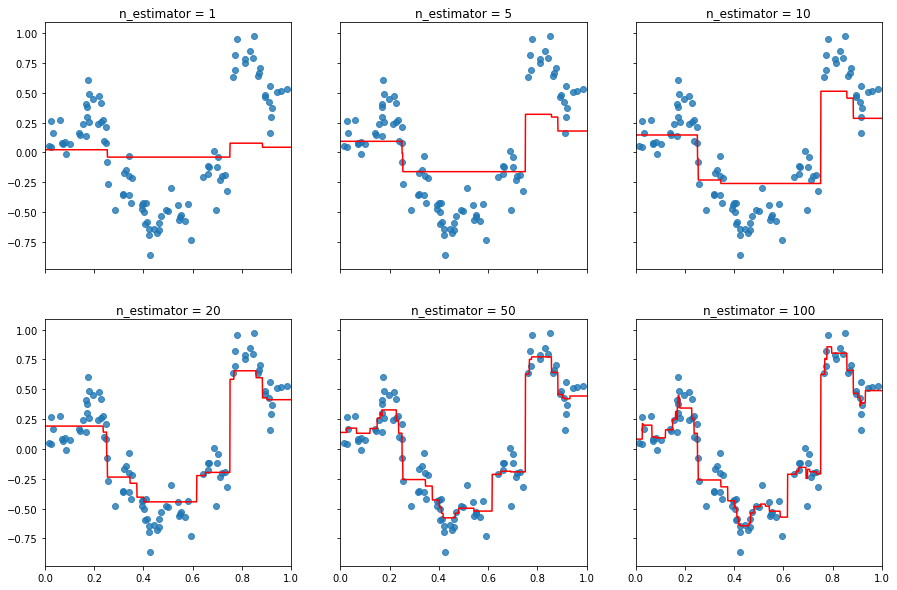

In [28]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)